# Education Network

## Imports and stuff

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import daft
from daft import PGM
from pgmpy.models import BayesianNetwork
from pgmpy.sampling import BayesianModelSampling, HamiltonianMC
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

In [69]:
# This method will allow us to avoid cpd truncation
def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup

## Plot the graph of the network

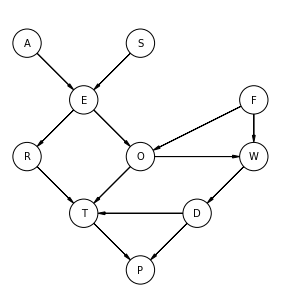

In [20]:
pgm = PGM(shape=[5, 5])

# Add the nodes to the net graph
pgm.add_node(daft.Node("A", r"A", 1, 5))
pgm.add_node(daft.Node("S", r"S", 3, 5))
pgm.add_node(daft.Node("E", r"E", 2, 4))
pgm.add_node(daft.Node("O", r"O", 3, 3))
pgm.add_node(daft.Node("R", r"R", 1, 3))
pgm.add_node(daft.Node("T", r"T", 2, 2))
pgm.add_node(daft.Node("F", r"F", 5, 4))
pgm.add_node(daft.Node("W", r"W", 5, 3))
pgm.add_node(daft.Node("D", r"D", 4, 2))
pgm.add_node(daft.Node("P", r"P", 3, 1))

# Add the edgest to the net graph
pgm.add_edge("A", "E")
pgm.add_edge("S", "E")
pgm.add_edge("E", "R")
pgm.add_edge("E", "O")
pgm.add_edge("F", "O")
pgm.add_edge("F", "W")
pgm.add_edge("O", "T")
pgm.add_edge("O", "W")
pgm.add_edge("R", "T")
pgm.add_edge("W", "D")
pgm.add_edge("D", "T")
pgm.add_edge("D", "P")
pgm.add_edge("T", "P")

pgm.render()
plt.show()

## Definition of the network

In [79]:
# Define variables (Will make easier to define the network)
A = "Age"
S = "Sex"
E = "Education"
O = "Occupation"
R = "Residence"
T = "Travel"

# Try to add another variable
F = "Field"
W = "Working Style"
D = "Distance"
P = "Pollution"

# DEFINE THE NETWORK STRUCTURES
# Define the arcs
#education_model = BayesianNetwork([(A,E),(S,E),(E,O),(E,R),(O,T),(R,T)])
education_model = BayesianNetwork([(A,E),(S,E),(E,O),(E,R),(F,O),(F,W),(O,T),(O,W),(W,D),(R,T),(D,T),(T,P),(D,P)])

# Define the conditional probability distributions(?)#TODO CPD == ?
age_cpd=TabularCPD(A,3,[[.3],
                        [.5],
                        [.2]],
                        state_names={A: ["young", "adult", "old"]})

sex_cpd=TabularCPD(S,2,[[.6],
                        [.4]],
                        state_names={S: ["male", "female"]})

edu_cpd=TabularCPD(E,2,[[.75,.72,.88,.64,.7,.9],
                        [.25,.28,.12,.36,.3,.1]],
                        evidence=[S,A],evidence_card=[2,3],
                        state_names={E: ["high", "uni"], S: ["male", "female"], A: ["young", "adult", "old"]})

"""
THIS TABLE IS MODIFIED LATER DUE TO THE NEW VARIABLES ADDED

ocu_cpd=TabularCPD(O,2,[[.96,.92],
                        [.04,.08]],
                        evidence=[E],evidence_card=[2],
                        state_names={O: ["emp", "self"], E: ["high", "uni"]})
"""


res_cpd=TabularCPD(R,2,[[.25,.2],
                        [.75,.8]],
                        evidence=[E],evidence_card=[2],
                        state_names={R: ["small", "big"], E: ["high", "uni"]})
"""
THIS TABLE IS MODIFIED LATER DUE TO THE NEW VARIABLES ADDED

tra_cpd=TabularCPD(T,3,[[.48,.58,.56,.7],
                        [.42,.24,.36,.21],
                        [.1,.18,.08,.09]],
                        evidence=[O,R], evidence_card=[2,2],
                        state_names={T: ["car", "train", "other"], O: ["emp", "self", "uemp"], R: ["small", "big"]})
"""

# CPD FOR THE NEW VARIABLES

fie_cpd=TabularCPD(F,4,[[.38],
                        [.22],
                        [.09],
                        [.31]],
                        state_names={F: ["Scientific", "Humanistic", "Artistic", "Social"]})

ocu_cpd=TabularCPD(O,2,[[.80,.90,.65,.86,.76,.86,.61,.82],
                        [.20,.10,.35,.14,.24,.14,.39,.18],],
                        evidence=[E,F], evidence_card=[2,4],
                        state_names={O: ["emp", "self"], E: ["high", "uni"], F: ["Scientific", "Humanistic", "Artistic", "Social"]})

wor_cpd=TabularCPD(W,2,[[.52,.17,.69,.22,.90,.83,.96,.85],
                        [.48,.83,.31,.78,.10,.17,.04,.15]],
                        evidence=[O,F], evidence_card=[2,4],
                        state_names={W: ["sw", "off"], O: ["emp", "self"], F: ["Scientific", "Humanistic", "Artistic", "Social"]})

dis_cpd=TabularCPD(D,2,[[.94,.65],
                        [.06,.35]],
                        evidence=[W], evidence_card=[2],
                        state_names={D: ["near", "far"], W: ["sw", "off"]})

tra_cpd=TabularCPD(T,3,[[.45,.48,.10,.53,.55,.58,.15,.60],
                        [.08,.42,.02,.38,.06,.33,.01,.32],
                        [.47,.10,.88,.09,.39,.09,.84,.08]],
                        evidence=[O,R,D], evidence_card=[2,2,2],
                        state_names={T: ["car", "train", "other"], O: ["emp", "self"], R: ["small", "big"], D: ["near", "far"]})

pol_cpd=TabularCPD(P,3,[[.63,.13,0,.85,.6,0],
                        [.3,.62,0,.13,.27,0],
                        [.07,.25,1,.02,.13,1]],
                        evidence=[D,T], evidence_card=[2,3],
                        state_names={P: ["high", "medium", "low"], D: ["near", "far"], T: ["car", "train", "other"]})

#education_model.add_cpds(age_cpd,sex_cpd,edu_cpd,ocu_cpd,res_cpd,tra_cpd)
education_model.add_cpds(age_cpd,sex_cpd,edu_cpd,ocu_cpd,fie_cpd,res_cpd,wor_cpd,dis_cpd,tra_cpd,pol_cpd)
# student_model.get_cpds()

In [80]:
education_model.check_model()

True

A smart student in an easy class is 90% likely to get an A, 8% likely to get a B, and 2% likely to get a C.
Conversely, a smart student in a hard class is only 50% likely to get an A

In [81]:
print(age_cpd) 
print(sex_cpd) 
print(edu_cpd) 
print(res_cpd) 
print(ocu_cpd)
print(tra_cpd)
print(pol_cpd)

+------------+-----+
| Age(young) | 0.3 |
+------------+-----+
| Age(adult) | 0.5 |
+------------+-----+
| Age(old)   | 0.2 |
+------------+-----+
+-------------+-----+
| Sex(male)   | 0.6 |
+-------------+-----+
| Sex(female) | 0.4 |
+-------------+-----+
+-----------------+------------+-----+-------------+-------------+
| Sex             | Sex(male)  | ... | Sex(female) | Sex(female) |
+-----------------+------------+-----+-------------+-------------+
| Age             | Age(young) | ... | Age(adult)  | Age(old)    |
+-----------------+------------+-----+-------------+-------------+
| Education(high) | 0.75       | ... | 0.7         | 0.9         |
+-----------------+------------+-----+-------------+-------------+
| Education(uni)  | 0.25       | ... | 0.3         | 0.1         |
+-----------------+------------+-----+-------------+-------------+
+------------------+-----------------+----------------+
| Education        | Education(high) | Education(uni) |
+------------------+--------

## Sample queries

We take three persons and we know they are male. One is young, the other one is adult and the last one is old. Let's compare the probabilities of pollutions of them.

In [39]:
# We will use exact inference by variable elimination
education_inference = VariableElimination(education_model)

# Perform the queries
pol_young = education_inference.query(variables=[P], evidence={A: "young", S: "male"})
pol_adult = education_inference.query(variables=[P], evidence={A: "adult", S: "male"})
pol_old = education_inference.query(variables=[P], evidence={A: "old", S: "male"})

# Print results
print("Probability of pollution of a young man:\n", pol_young, "\n")
print("Probability of pollution of an adult man:\n", pol_adult, "\n")
print("Probability of pollution of an old man:\n", pol_old, "\n")

Probability of pollution of a young man:
 +-------------------+------------------+
| Pollution         |   phi(Pollution) |
+===================+==================+
| Pollution(high)   |           0.2482 |
+-------------------+------------------+
| Pollution(medium) |           0.0992 |
+-------------------+------------------+
| Pollution(low)    |           0.6527 |
+-------------------+------------------+ 

Probability of pollution of an adult man:
 +-------------------+------------------+
| Pollution         |   phi(Pollution) |
+===================+==================+
| Pollution(high)   |           0.2479 |
+-------------------+------------------+
| Pollution(medium) |           0.0990 |
+-------------------+------------------+
| Pollution(low)    |           0.6532 |
+-------------------+------------------+ 

Probability of pollution of an old man:
 +-------------------+------------------+
| Pollution         |   phi(Pollution) |
+===================+==================+
| Polluti

Even if the probabilities between them are very similar, we are more interested in the comparison. We can inmediately notice that the probability of polluting high of an old man is slightly higher than the one of an adult and a young man.

In [40]:
# Probability of residence given W = Smart Working
res_prob = education_inference.query(variables=[R], evidence={W: "sw"})
print(res_prob)

+------------------+------------------+
| Residence        |   phi(Residence) |
+==================+==================+
| Residence(small) |           0.2368 |
+------------------+------------------+
| Residence(big)   |           0.7632 |
+------------------+------------------+


In [41]:
field_prob1 = education_inference.query(variables=[F], evidence={P: "high"})
field_prob2 = education_inference.query(variables=[F], evidence={P: "medium"})
field_prob3 = education_inference.query(variables=[F], evidence={P: "low"})
print(field_prob1)
print(field_prob2)
print(field_prob3)

+-------------------+--------------+
| Field             |   phi(Field) |
+===================+==============+
| Field(Scientific) |       0.3445 |
+-------------------+--------------+
| Field(Humanistic) |       0.2471 |
+-------------------+--------------+
| Field(Artistic)   |       0.0727 |
+-------------------+--------------+
| Field(Social)     |       0.3356 |
+-------------------+--------------+
+-------------------+--------------+
| Field             |   phi(Field) |
+===================+==============+
| Field(Scientific) |       0.3648 |
+-------------------+--------------+
| Field(Humanistic) |       0.2314 |
+-------------------+--------------+
| Field(Artistic)   |       0.0830 |
+-------------------+--------------+
| Field(Social)     |       0.3209 |
+-------------------+--------------+
+-------------------+--------------+
| Field             |   phi(Field) |
+===================+==============+
| Field(Scientific) |       0.3958 |
+-------------------+--------------+
|

## Generation of data

In [82]:
datasets = []
n_vector = [1e1, 1e2, 1e3, 1e4, 1e5, 1e6]

for n in n_vector:
    datasets.append(BayesianModelSampling(education_model).forward_sample(size=int(n)))

datasets[0].head()

Generating for node: Pollution: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]   


,Age,Education,Sex,Occupation,Residence,Field,Working Style,Travel,Distance,Pollution
0,old,high,female,emp,big,Scientific,sw,other,near,low
1,adult,high,male,emp,small,Scientific,sw,other,near,low
2,adult,high,female,emp,big,Scientific,off,train,far,medium
3,young,high,male,emp,big,Scientific,sw,other,near,low
4,adult,high,male,emp,big,Scientific,off,other,near,low


In [85]:
"""
for dataset in datasets:
    mle = MaximumLikelihoodEstimator(model=education_model, data=dataset)
    np.allclose(
        education_model.get_cpds(P).values, mle.estimate_cpd(P).values, atol=0.01
    )
"""

best = BayesianEstimator(model=education_model, data=datasets[2])

print_full(pol_cpd)
print_full(best.estimate_cpd(node=P))
#print_full((mle.estimate_cpd(node=P)))

+-------------------+----------------+----------------+----------------+---------------+---------------+---------------+
| Distance          | Distance(near) | Distance(near) | Distance(near) | Distance(far) | Distance(far) | Distance(far) |
+-------------------+----------------+----------------+----------------+---------------+---------------+---------------+
| Travel            | Travel(car)    | Travel(train)  | Travel(other)  | Travel(car)   | Travel(train) | Travel(other) |
+-------------------+----------------+----------------+----------------+---------------+---------------+---------------+
| Pollution(high)   | 0.63           | 0.13           | 0.0            | 0.85          | 0.6           | 0.0           |
+-------------------+----------------+----------------+----------------+---------------+---------------+---------------+
| Pollution(medium) | 0.3            | 0.62           | 0.0            | 0.13          | 0.27          | 0.0           |
+-------------------+-----------